# Intro

In [3]:
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

from scipy import stats

import xarray as xa

from scipy.stats import t

import statsmodels.api as sm


In [4]:
from sklearn.linear_model import LinearRegression

In [5]:
tinv = lambda p, df: abs(t.ppf(p/2, df))
ts = tinv(0.05, 222-1)
ts


1.970756270488079

In [6]:
all0205 = xa.open_dataset("../daa/atropics/CERES_FluxByCldTyp-MON_Terra-Aqua-MODIS_Ed4.1_Subset_200207-200505.nc", engine='netcdf4')
all0508 = xa.open_dataset("../daa/atropics/CERES_FluxByCldTyp-MON_Terra-Aqua-MODIS_Ed4.1_Subset_200506-200804.nc", engine='netcdf4')
all0811 = xa.open_dataset("../daa/atropics/CERES_FluxByCldTyp-MON_Terra-Aqua-MODIS_Ed4.1_Subset_200805-201103.nc", engine='netcdf4')
all1114 = xa.open_dataset("../daa/atropics/CERES_FluxByCldTyp-MON_Terra-Aqua-MODIS_Ed4.1_Subset_201104-201402.nc", engine='netcdf4')
all1417 = xa.open_dataset("../daa/atropics/CERES_FluxByCldTyp-MON_Terra-Aqua-MODIS_Ed4.1_Subset_201403-201701.nc", engine='netcdf4')
all1821 = xa.open_dataset("../daa/atropics/CERES_FluxByCldTyp-MON_Terra-Aqua-MODIS_Ed4.1_Subset_201702-201912.nc", engine='netcdf4')
all2123 = xa.open_dataset("../daa/atropics/CERES_FluxByCldTyp-MON_Terra-Aqua-MODIS_Ed4.1_Subset_202001-202211.nc", engine='netcdf4')
all2223 = xa.open_dataset("../daa/atropics/CERES_FluxByCldTyp-MON_Terra-Aqua-MODIS_Ed4.1_Subset_202212-202302.nc", engine='netcdf4')

In [7]:
var = "toa_lw"
alllw = xa.concat( [all0205[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_lw_clr_mon"]],
                    all0508[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_lw_clr_mon"]],
                    all0811[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_lw_clr_mon"]],
                    all1114[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_lw_clr_mon"]],
                    all1417[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_lw_clr_mon"]],
                    all1821[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_lw_clr_mon"]],
                    all2123[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_lw_clr_mon"]],], 
               dim='time')

In [8]:
var = "toa_sw"
allsw = xa.concat( [all0205[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_sw_clr_mon"]],
                    all0508[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_sw_clr_mon"]],
                    all0811[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_sw_clr_mon"]],
                    all1114[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_sw_clr_mon"]],
                    all1417[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_sw_clr_mon"]],
                    all1821[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_sw_clr_mon"]],
                    all2123[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_sw_clr_mon"]],], 
               dim='time')

In [9]:
#Gistemp Surface temp by lat, lon and time
#st_global_anom_raghu = xa.open_dataset("../daa/gistemp1200_GHCNv4_ERSSTv5.nc").sel(time=ragutime).tempanomaly
#gmst_anom_raghu = st_global_anom_raghu.mean(["lat", "lon"])
#gmst_anom_raghu 

In [10]:
#0
trop = slice(-30,30)
ragutime = slice('2002-07-15T00:00:00.000000000',\
                 '2020-12-15T00:00:00.000000000' )

# Tropics

## Kernels

In [11]:
RclrLW_trop = alllw.sel(lat=trop,time=ragutime).toa_lw_clr_mon.mean(["lon"])
RovcLW_trop = alllw.sel(lat=trop,time=ragutime).toa_lw_cldtyp_mon.mean(["lon"])
lwK_trop = (RclrLW_trop - RovcLW_trop)/100

In [12]:
RclrSW_trop = allsw.sel(lat=trop,time=ragutime).toa_sw_clr_mon.mean("lon")
RovcSW_trop = allsw.sel(lat=trop,time=ragutime).toa_sw_cldtyp_mon.mean("lon")
swK_trop = (RclrSW_trop - RovcSW_trop)/100

In [13]:
#1d
#If I dont mean over lon before, this will have loads of nans
K_trop = lwK_trop + swK_trop

Text(0.5, 1.0, 'c) Tropical-mean net kernel')

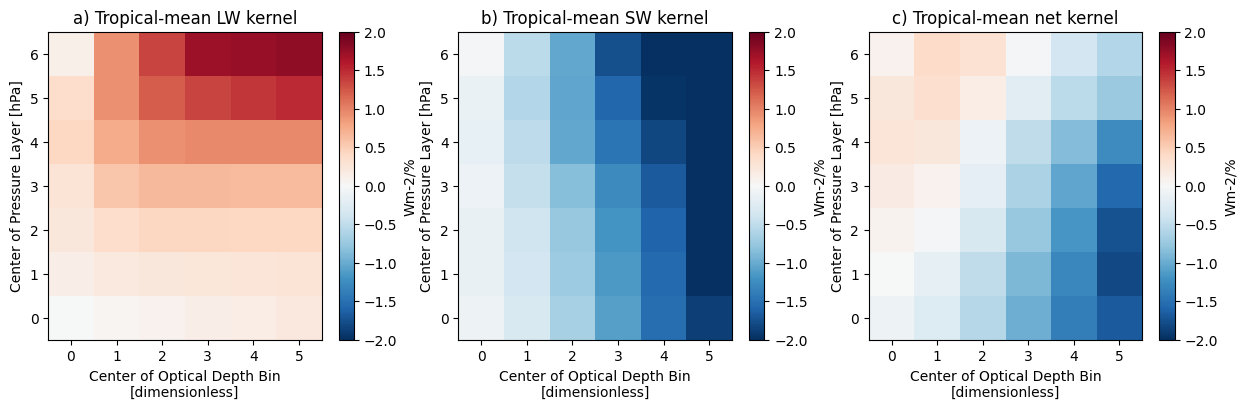

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))

#fig.suptitle('Horizontally stacked subplots')
lwK_trop.mean(["lat","time"]).transpose().plot(cmap="RdBu_r", vmin=-2.0, vmax=2.0, cbar_kwargs={'label': "Wm-2/%", 'extend': 'neither'}, ax=ax1)
ax1.set_title("a) Tropical-mean LW kernel")
swK_trop.mean(["lat","time"]).transpose().plot(cmap="RdBu_r", vmin=-2.0, vmax=2.0, cbar_kwargs={'label': "Wm-2/%", 'extend': 'neither'}, ax=ax2)
ax2.set_title("b) Tropical-mean SW kernel")
K_trop.mean(["lat","time"]).transpose().plot(cmap="RdBu_r", vmin=-2.0, vmax=2.0, cbar_kwargs={'label': "Wm-2/%", 'extend': 'neither'}, ax=ax3)
ax3.set_title("c) Tropical-mean net kernel")
#plt.savefig("kernels.png")

In [15]:
#Another way of testing if the kernels values are ok
p = np.array([1000.0 ,  800.0,  680,  560,  440, 310.0,  180,  10])
midpoints = [(p[i] + p[i -1])/2 for i in np.arange(len(p)) ]
midpoints

[505.0, 900.0, 740.0, 620.0, 500.0, 375.0, 245.0, 95.0]

Text(0.5, 1.0, 'Kernel values at misdpoint pressure bins')

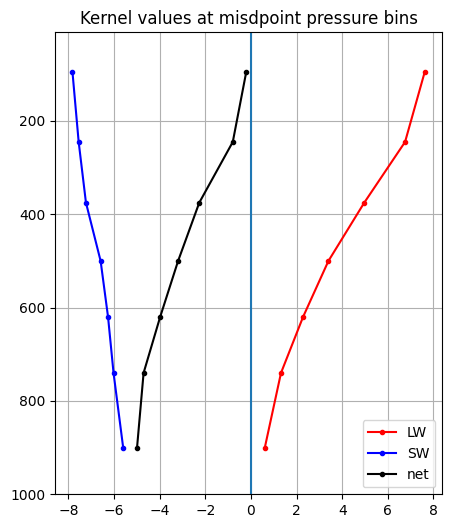

In [16]:
plt.figure(figsize=(5,6))
plt.plot(lwK_trop.mean(["lat","time"]).sum("opt"),  midpoints[1:], ".-r", label="LW")
plt.plot(swK_trop.mean(["lat","time"]).sum("opt"),  midpoints[1:], ".-b", label="SW")
plt.plot(K_trop.mean(["lat","time"]).sum("opt"), midpoints[1:], ".-k", label="net")
plt.gca().invert_yaxis()
plt.ylim(1000,10)
plt.vlines(0, ymin=1000, ymax=10)
plt.grid()
plt.legend()
plt.title("Kernel values at misdpoint pressure bins")
#plt.savefig("kernels_values.png")

In [17]:
#2
area_trop = alllw.cldarea_cldtyp_mon.sel(lat=trop, time=ragutime).mean("lon")
cc_trop_anom = area_trop.groupby('time.month')- area_trop.groupby('time.month').mean('time')

In [18]:
#3
#NOtice! If I mean over lon here rather than when calculating the kernels, the feedback values change slightly (further away than raghuraman's)
#IN the seconfnd 
lwR_trop = lwK_trop.mean("time")*cc_trop_anom
swR_trop = swK_trop.mean("time")*cc_trop_anom

In [19]:
# Rp = K_trop.sum("opt")*cc_trop_anom.sum("opt")
# Rp.sum("press").mean("lat")

# Rtau = K_trop.sum("press")*cc_trop_anom.sum("press")
# Rtau.sum("opt").mean("lat")

In [20]:
weights = np.cos(np.deg2rad(swR_trop.lat))
weights

<xarray.DataArray 'lat' (lat: 60)>
array([0.87035567, 0.87881714, 0.8870108 , 0.89493436, 0.90258527,
       0.9099613 , 0.9170601 , 0.9238795 , 0.9304176 , 0.9366722 ,
       0.9426415 , 0.94832367, 0.95371693, 0.95881975, 0.96363044,
       0.96814764, 0.9723699 , 0.976296  , 0.9799247 , 0.9832549 ,
       0.9862856 , 0.9890159 , 0.9914449 , 0.9935719 , 0.9953962 ,
       0.9969173 , 0.9981348 , 0.99904823, 0.99965733, 0.9999619 ,
       0.9999619 , 0.99965733, 0.99904823, 0.9981348 , 0.9969173 ,
       0.9953962 , 0.9935719 , 0.9914449 , 0.9890159 , 0.9862856 ,
       0.9832549 , 0.9799247 , 0.976296  , 0.9723699 , 0.96814764,
       0.96363044, 0.95881975, 0.95371693, 0.94832367, 0.9426415 ,
       0.9366722 , 0.9304176 , 0.9238795 , 0.9170601 , 0.9099613 ,
       0.90258527, 0.89493436, 0.8870108 , 0.87881714, 0.87035567],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 -29.5 -28.5 -27.5 -26.5 -25.5 ... 26.5 27.5 28.5 29.5
Attributes:
    long_name:      Latitude
    standard_name:  latitude
    units:          degrees_north
    valid_range:    [-90.  90.]

In [21]:
#4
lwR_trop_mean = lwR_trop.mean(["lat"]) #.weighted(weights=weights)
swR_trop_mean = swR_trop.mean(["lat"]) #.weighted(weights=weights)

### GMST

In [22]:
#5
#Gistemp GMST anomalies
gmst1850 = pd.read_csv("../daa/GLB.Ts+dSST.csv", skiprows=[0])

gmst = gmst1850.loc[ gmst1850['Year'] >= 2002 ]
gmst = gmst.loc[ gmst['Year'] < 2021 ]
lista_gmst = gmst[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep','Oct', 'Nov', 'Dec']].values.flatten().tolist()
#lista_gmst, len(lista_gmst)
lista_gmst[6:]
#NOT the same as meaqning across all the values, which gives:0.7340974 , 0.23327379, 0.95729756, 0.8614268 , 0.7519227... 
gmst_anom_raghu = np.array(lista_gmst[6:], dtype=np.float16)
gmst_anom_raghu.shape

(222,)

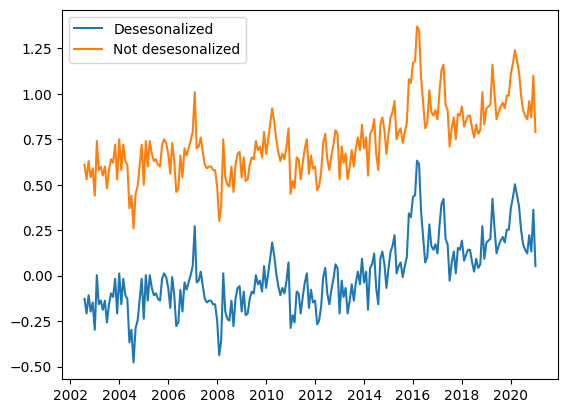

In [23]:
mean0220 = np.mean(gmst_anom_raghu)
corregido = gmst_anom_raghu - mean0220
corregido.shape
start_date = "2002-07"  # January 1850
end_date = "2021-01"    # December 2020

# Generate the monthly dates
dates = pd.date_range(start=start_date, end=end_date, freq="M").to_numpy()
plt.plot(dates,corregido, label="Desesonalized")
plt.plot(dates,gmst_anom_raghu, label="Not desesonalized")
plt.legend()

In [24]:
from sklearn.linear_model import LinearRegression

In [25]:
#x=np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]).reshape(-1,1)
#y=np.array([0.113, 0.116, 0.130, 0.150, 0.150, 0.160, 0.180, 0.210, 0.220, 0.260, 0.280])

y = lwR_trop_mean.sel(press=1, opt=1).data
x = corregido.reshape(-1,1)
regression=LinearRegression(fit_intercept=False).fit(x,y)
regression.coef_[0], regression.intercept_
#plt.scatter(corregido, lwR_trop_mean.sel(press=1, opt=1))
#plt.plot(corregido, lw_regress.slope*corregido + lw_regress.intercept, "-r")

#slope_no_intercept = np.sum((bint- bint.mean("time")) * (gmst_anom_raghu- np.mean(gmst_anom_raghu))) / np.sum((gmst_anom_raghu - np.mean(gmst_anom_raghu))**2)
#print(slope_no_intercept)
#lw_regress.slope, lw_regress.stderr, lw_regress.intercept, lw_regress.intercept_stderr

#regression=LinearRegression(fit_intercept=True).fit(x,y)

(-0.034502313, 0.0)

In [26]:
regression.score(x,y)

0.07399845123291016

In [27]:
bint = lwR_trop_mean.sel(press=1, opt=1)
bintmean = bint.mean()
new_intercept = bintmean - lw_regress.slope * mean0220
new_intercept

NameError: name 'lw_regress' is not defined

In [23]:

lw_regress = stats.linregress(corregido, bint)
plt.scatter(corregido, lwR_trop_mean.sel(press=1, opt=1))
plt.plot(corregido, lw_regress.slope*corregido + lw_regress.intercept, "-r")

slope_no_intercept = np.sum((bint- bint.mean("time")) * (gmst_anom_raghu- np.mean(gmst_anom_raghu))) / np.sum((gmst_anom_raghu - np.mean(gmst_anom_raghu))**2)
print(slope_no_intercept)
lw_regress.slope, lw_regress.stderr, lw_regress.intercept, lw_regress.intercept_stderr

NameError: name 'bint' is not defined

### Total Feedbacks

In [28]:
#6
lw_feed_slope =  np.zeros([7,6])
lw_feed_st =  np.zeros([7,6])

for od in [0,1,2,3,4,5]:
    for p in [0,1,2,3,4,5,6]:
        bint = lwR_trop_mean.sel(press=p, opt=od)
        #lw_regress = stats.linregress(corregido, bint)
        lw_regress = sm.OLS(bint.data, corregido.astype("float32")).fit()
        lw_feed_slope[p, od] = lw_regress.params[0] #.slope
        lw_feed_st[p, od] = lw_regress.bse[0] #.stderr

lwfeed_trops = xa.DataArray(lw_feed_slope,
                    coords={"press": lwR_trop_mean.press, "opt":lwR_trop_mean.opt, 
                           },
                   )

lwfeed_trops_st = xa.DataArray(lw_feed_st,
                    coords={"press": lwR_trop_mean.press, "opt":lwR_trop_mean.opt, 
                           },
                   )

In [29]:
lw_regress.rsquared_adj

0.06097789048069746

In [31]:
ts, lwfeed_trops_st.sum(["opt", "press"]).data

(1.970756270488079, array(0.4490752))

In [32]:
ci_low =  lwfeed_trops-ts* lwfeed_trops_st
ci_upp =  lwfeed_trops+ts* lwfeed_trops_st
(ts* lwfeed_trops_st).sum(["opt", "press"])

<xarray.DataArray ()>
array(0.88501776)

In [33]:
ci_low.sel(press=[4,5,6]).sum(["opt", "press"]).data, ci_upp.sel(press=[4,5,6]).sum(["opt", "press"]).data

(array(-0.9928345), array(0.29812049))

In [34]:
lw_feed_slope[1,1]

-0.034502606838941574

In [35]:
# Calculate degrees of freedom
n = 222  # Number of data points
dof = n - 1 # Only the slope is estimated

# Calculate critical t-value for 95% confidence
t_crit = t.ppf(0.975, dof)

std_errors_slope = lwfeed_trops_st.sel(press=[4,5,6]).sum(["press", "opt"]).data
total_variance_slope = np.sum(std_errors_slope ** 2)
SE_sum_slope = np.sqrt(total_variance_slope)
slope = -0.34735700697638094 
# Compute the confidence intervals
slope_ci = (slope- t_crit * SE_sum_slope, slope + t_crit * SE_sum_slope)

print(f"Slope: {slope:.4f}")
print(f"Slope: {total_variance_slope:.4f}")
print(f"95% Confidence Interval for Slope: {slope_ci}")
t_crit# * np.sum(std_errors_slope)


Slope: -0.3474
Slope: 0.1073
95% Confidence Interval for Slope: (-0.9928345012496785, 0.29812048729691665)


1.9707562704880786

Tropical LW feedback =  -0.5107747220317833
High cloud Tropical LW feedback =  -0.34735700697638094 +- 0.32752781454473734
Low-mid cloud Tropical LW feedback =  -0.16341771505540237


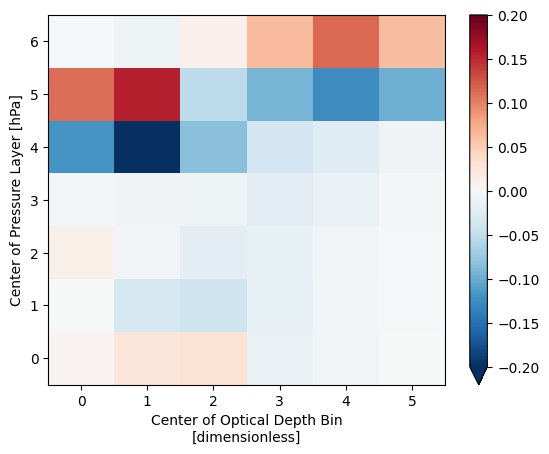

In [77]:
print("Tropical LW feedback = ", lwfeed_trops.sum(["opt", "press"]).data)
print("High cloud Tropical LW feedback = ", lwfeed_trops.sel(press=[4,5,6]).sum(["press", "opt"]).data,"+-" ,lwfeed_trops_st.sel(press=[4,5,6]).sum(["press", "opt"]).data)
print("Low-mid cloud Tropical LW feedback = ", lwfeed_trops.sel(press=[0,1,2,3]).sum(["press", "opt"]).data)
lwfeed_trops.plot(vmin=-0.2, vmax=0.2, cmap="RdBu_r")
#-0.5034, -0.3448, -0.1586

In [37]:
print("Tropical LW feedback sd = ", np.sum( lw_feed_st))
print("High cloud Tropical LW feedback = ", np.sum( lw_feed_st[4:,:]))
print("Low-mid cloud Tropical LW feedback = ", np.sum( lw_feed_st[:4,:]))
#lwfeed_trop.plot(vmin=-0.2, vmax=0.2, cmap="RdBu_r")

Tropical LW feedback sd =  0.44907519849948585
High cloud Tropical LW feedback =  0.32752781454473734
Low-mid cloud Tropical LW feedback =  0.12154738395474851


In [65]:
#6
sw_feed =  np.zeros([7,6])
sw_feed_st = np.zeros([7,6])

for od in [0,1,2,3,4,5]:
    for p in [0,1,2,3,4,5,6]:
        bints = swR_trop_mean.sel(press=p, opt=od)
        sw_regress = stats.linregress(gmst_anom_raghu, bints)
        sw_feed[p, od] = sw_regress.slope
        sw_feed_st[p, od] = sw_regress.stderr

swfeed_trops = xa.DataArray(sw_feed, 
                    coords={"press": swR_trop_mean.press, "opt":swR_trop_mean.opt, 
                           },
                   )

swfeed_trops_st = xa.DataArray(sw_feed_st, 
                    coords={"press": swR_trop_mean.press, "opt":swR_trop_mean.opt, 
                           },
                   )

0.7855354954901275 0.7061748018147223
High cloud Tropical SW feedback =  0.43392271698881896 +- 0.3194521059663735
Low-mid cloud Tropical SW feedback =  0.35161277850130856


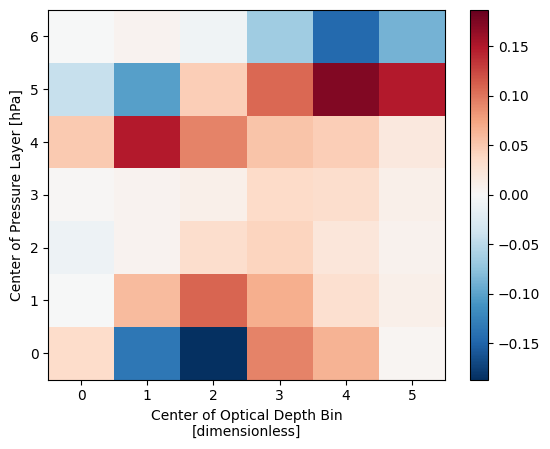

In [75]:
print(swfeed_trops.sum(["press", "opt"]).data, swfeed_trops_st.sum(["press", "opt"]).data) 
print("High cloud Tropical SW feedback = ", swfeed_trops.sel(press=[4,5,6]).sum(["press", "opt"]).data,"+-" ,swfeed_trops_st.sel(press=[4,5,6]).sum(["press", "opt"]).data)
print("Low-mid cloud Tropical SW feedback = ", swfeed_trops.sel(press=[0,1,2,3]).sum(["press", "opt"]).data)
(swfeed_trops).plot()
# 0.7710, 0.4199, 0.3511

In [30]:
print("Tropical SW feedback sd = ", np.sum( sw_feed_st))
print("High cloud Tropical SW feedback = ", np.sum( sw_feed_st[4:,:]))
print("Low-mid cloud Tropical SW feedback = ", np.sum( sw_feed_st[:4,:]))

Tropical SW feedback sd =  0.7061748018147223
High cloud Tropical SW feedback =  0.3194521059663735
Low-mid cloud Tropical SW feedback =  0.3867226958483488


In [39]:
#6
netR_trop = K_trop.mean("time")*cc_trop_anom

netR_trop_mean = netR_trop.mean(["lat"]) #weighted(weights=weights).

net_feed =  np.zeros([7,6])
net_feed_st = np.zeros([7,6])

for od in [0,1,2,3,4,5]:
    for p in [0,1,2,3,4,5,6]:
        bints = netR_trop_mean.sel(press=p, opt=od)
        net_regress = stats.linregress(gmst_anom_raghu, bints)
        net_feed[p, od] = net_regress.slope
        net_feed_st[p, od] = net_regress.stderr

netfeed_tropsr = xa.DataArray(net_feed, 
                    coords={"press": netR_trop_mean.press, "opt":netR_trop_mean.opt, 
                           },
                   )

netfeed_trop_st = xa.DataArray(net_feed_st, 
                    coords={"press": netR_trop_mean.press, "opt":netR_trop_mean.opt, 
                           },
                   )

0.27476075782517784 0.3926252560485955
High cloud Tropical net feedback =  0.08656580758728014
Low-mid cloud Tropical net feedback =  0.18819495023789767


NameError: name 't_value' is not defined

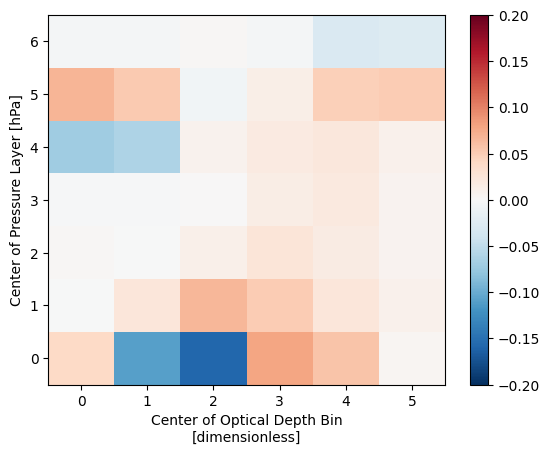

In [40]:
#netfeed_trops = swfeed_trops + lwfeed_trops
print(netfeed_tropsr.sum(["press", "opt"]).data, netfeed_trop_st.sum(["press", "opt"]).data)
print("High cloud Tropical net feedback = ", netfeed_tropsr.sel(press=[4,5,6]).sum(["press", "opt"]).data)
print("Low-mid cloud Tropical net feedback = ", netfeed_tropsr.sel(press=[0,1,2,3]).sum(["press", "opt"]).data)
netfeed_tropsr.plot(vmin=-0.2, vmax=0.2, cmap="RdBu_r")

# Calculate the variance of the sum
# Como estoy calculando el total como la suma de los bins, la desviacion std es tambien la suma de las desvst
variance_of_sum = netfeed_trop_st.sel(press=[4,5,6]).sum(["press", "opt"])**2

# Standard deviation of the sum
sd_of_sum = np.sqrt(variance_of_sum.data)

# Confidence interval
ci = t_value * sd_of_sum

print(netfeed_tropsr.sel(press=[4,5,6]).sum(["press", "opt"]).data - ci , netfeed_tropsr.sel(press=[4,5,6]).sum(["press", "opt"]).data+ci)
print(ci)

In [41]:
import statsmodels.api as sm
xs = gmst_anom_raghu
xs = sm.add_constant( xs )
ys = bints.data
model = sm.OLS( ys, xs )
results = model.fit()
results

In [42]:
results.conf_int( alpha=0.05 )

array([[ 0.01143084,  0.02918191],
       [-0.03918098, -0.01587604]])

Text(0.5, 1.0, 'c) Tropical-mean net feedback')

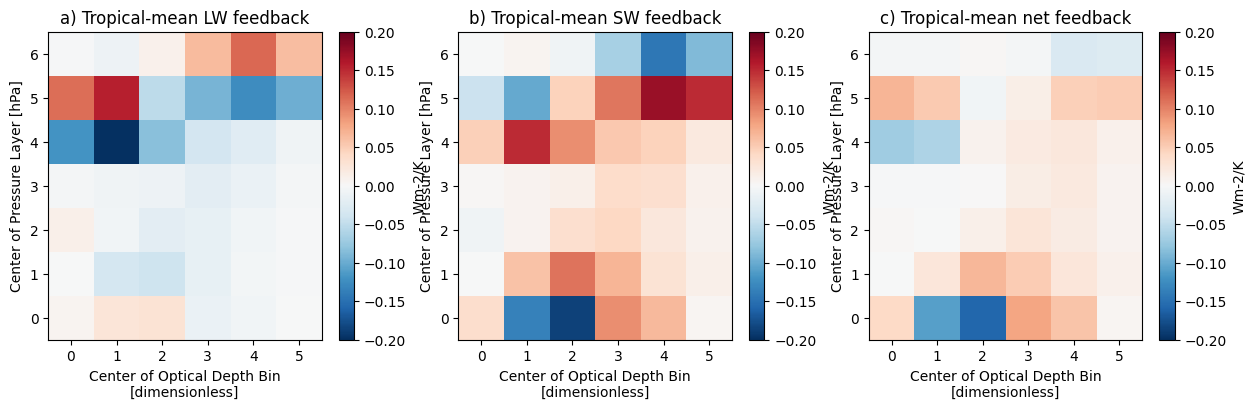

In [43]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))

#fig.suptitle('Horizontally stacked subplots')
lwfeed_trops.plot(cmap="RdBu_r", vmin=-0.2, vmax=0.2, cbar_kwargs={'label': "Wm-2/K", 'extend': 'neither'}, ax=ax1)
ax1.set_title("a) Tropical-mean LW feedback")
swfeed_trops.plot(cmap="RdBu_r", vmin=-0.2, vmax=0.2, cbar_kwargs={'label': "Wm-2/K", 'extend': 'neither'}, ax=ax2)
ax2.set_title("b) Tropical-mean SW feedback")
netfeed_tropsr.plot(cmap="RdBu_r", vmin=-0.2, vmax=0.2, cbar_kwargs={'label': "Wm-2/K", 'extend': 'neither'}, ax=ax3)
ax3.set_title("c) Tropical-mean net feedback")
#plt.savefig("feedbacks.png")

In [44]:
#CIsw_reg = stats.linregress(gmst_anom_raghu, swR_trop_mean.sel(press=1, opt=1))
sw_reg.slope

from scipy.stats import t
tinv = lambda p, df: abs(t.ppf(p/2, df))
ts = tinv(0.05, len(gmst_anom_raghu)-2)
ts*sw_reg.stderr

NameError: name 'sw_reg' is not defined

## Decomposition

In [45]:
# Calculate the critical t-value
t_value = t.ppf(0.975, df=222-1) # Number of data points per regression - Number of predictors (slope only)

#RAGHURAMAN'S net feedback res 
0.09 - 0.12 - 0.06 +0.05

-0.039999999999999994

In [46]:
cTot_anom = (cc_trop_anom.sel(press=[4,5,6]).sum(["press", "opt"])) # .mean("lat")
cTot = (area_trop.sel(press=[4,5,6]).sum(["press", "opt"])) # .mean("lat")

#I have tried meaning mlat before but it's worse

In [47]:
def hc_feedbacks(area,K,which, sst_anom=gmst_anom_raghu):
    
    i = ["press", "opt"]
    if which not in i:
        raise NameError(f"Decompsitions only in {i} dims")
    
    opp  = i[i.index(which) - 1]

    cTot = (area.sel(press=[4,5,6]).sum(["press", "opt"])) 
    cc_anom = area.sel(press=[4,5,6]).groupby('time.month')- area.sel(press=[4,5,6]).groupby('time.month').mean('time')
    cTot_anom = (cc_anom.sel(press=[4,5,6]).sum(["press", "opt"]))
    
    cc_ast = cc_anom - (area.sel(press=[4,5,6])/cTot)*cTot_anom

    ci_Tot = (area.sel(press=[4,5,6])/cTot).sum(which)
    Ktau = K.sel(press=[4,5,6])*ci_Tot.sum(opp)

    K_prima = (Ktau * ci_Tot).sum(opp)

    casi_R = K_prima*cc_ast.sum(opp)

    R_altitude = casi_R.sum(which)

    feedback_i = stats.linregress(sst_anom, R_altitude.mean("lat"))
    
    return feedback_i.slope, feedback_i.stderr

### Amount

In [48]:
def feedback_amount(area,K, sst_anom):
    cTot = area.sum(["press", "opt"])
    cc_anom = area.groupby("time.month") - area.groupby("time.month").mean("time")
    cTot_anom = cc_anom.sum(["press", "opt"])
    K_0 = ((area/cTot)*K).sum(["opt", "press"])
    Ramt_anom = K_0*cTot_anom
    regress = stats.linregress(sst_anom, Ramt_anom.mean("lat"))
    return regress.slope, regress.stderr

In [49]:
#option 3 -> The one 
K_0_hc = (((area_trop.sel(press=[4,5,6])/cTot))*K_trop.sel(press=[4,5,6])).sum(["opt", "press"])
Ramt_anom = K_0_hc*cTot_anom
Ramt_anom.dims
stats.linregress(gmst_anom_raghu, Ramt_anom.mean("lat")).slope, ts*stats.linregress(gmst_anom_raghu, Ramt_anom.mean("lat")).stderr

(-0.05191400099916782, 0.0641640384612289)

steps:

1- select high clouds from kernel and area

2- compute the equation. C and Ctot must be already summed

3- sum what needs to be summed, either od or press, once the equation is computed

4- Keep lat until just before regressing

### Altitude

In [50]:
cc_anom = area_trop.sel(press=[4,5,6]).groupby('time.month')- area_trop.sel(press=[4,5,6]).groupby('time.month').mean('time')

In [51]:
cc_ast = cc_anom - (area_trop.sel(press=[4,5,6])/cTot)*cTot_anom

In [52]:
cpTot = (area_trop.sel(press=[4,5,6])/cTot).sum("press")
Ktau = K_trop.sel(press=[4,5,6])*cpTot.sum("opt")
Ktau.dims

K_prima = (Ktau * cpTot).sum("opt")
K_prima.dims

casi_R = K_prima*cc_ast.sum("opt")
casi_R.dims
R_altitude = casi_R.sum("press")

feed_altitude = stats.linregress(gmst_anom_raghu, R_altitude.mean("lat"))
feed_altitude.slope, ts*feed_altitude.stderr

(0.10925223262524657, 0.02378695405481745)

### Optical depth

In [53]:
ctTot = (area_trop.sel(press=[4,5,6])/cTot).sum("opt")
Kp = K_trop.sel(press=[4,5,6])*ctTot.sum("press")
print(Kp.dims)

K_prima_t = (Kp * ctTot).sum("press")
print(K_prima_t.dims)
casi_R = K_prima_t*cc_ast.sum("press")
R_tau = casi_R.sum("opt")

feed_od = stats.linregress(gmst_anom_raghu, R_tau.mean("lat"))
feed_od.slope, ts*feed_od.stderr

('time', 'lat', 'opt', 'press')
('time', 'lat', 'opt')


(0.06477566182591352, 0.08998700206696622)

### Rest

In [54]:
rest =  0.07453115191492792 - (-0.05191400099916782) - feed_altitude.slope - feed_od.slope
rest_ci = 0.39263 - 0.0642 - 0.02378 - 0.0899
#total 
rest, rest_ci

(-0.047582741537064335, 0.21475)

In [55]:
#another test
net_feed =  np.zeros([6])
for od in [0,1,2,3,4,5]:
    bints = netR_trop_mean.sel( press=[4,5,6]).sum("press").sel( opt=od)
    net_regress = stats.linregress(gmst_anom_raghu, bints)
    net_feed[od] = net_regress.slope

net_feed

net_feed.sum() #result=0.074

0.08656580621537543

In [56]:
# def feedback(K, area, type):

#     which = ["press", "opt"]
#     opp  = which[which.index(type) - 1]
    
#     cTot = area.sum(which)
    
#     cc_anom = area.groupby('time.month')- area.groupby('time.month').mean('time')
#     cTot_anom = cc_anom.sum(which)

#     cpTot = (area/cTot).sum(type)
#     Ktau = (K*cpTot).sum(opp)

#     Rtau = (Ktau * cc_anom).sum(opp)
#     Rtau_mean = Rtau.sum(type).mean("lat")

#     feed = stats.linregress(gmst_anom_raghu, Rtau_mean).slope

#     return feed

### LW and SW

In [62]:
a = feedback_amount(area_trop.sel(press=[4,5,6]), lwK_trop.sel(press=[4,5,6]), gmst_anom_raghu)

b = hc_feedbacks(area_trop, lwK_trop, "press")

c = hc_feedbacks(area_trop, lwK_trop, "opt")

res = lwfeed_trops.sel(press=[4,5,6]).sum(["press", "opt"]).data - a[0]-b[0]-c[0]

print(f"hc amount = {a[0]} +- {ts*a[1]}")
print(f"hc altitude = {b[0]} +- {ts*b[1]}")
print(f"hc od = {c[0]} +- {ts*c[1]}")
print(f"hc res = {res} +-{ts} ")

hc amount = -0.3411118172075701 +- 0.30559202952775716
hc altitude = 0.12959064140593823 +- 0.02896318662575861
hc od = -0.13094544900281374 +- 0.1281903949560082
hc res = -0.004890382171935326 +-1.970756270488079 


In [72]:
a = feedback_amount(area_trop.sel(press=[4,5,6]), swK_trop.sel(press=[4,5,6]), gmst_anom_raghu)

b = hc_feedbacks(area_trop, swK_trop, "press")

c = hc_feedbacks(area_trop, swK_trop, "opt")

res = swfeed_trops.sel(press=[4,5,6]).sum(["press", "opt"]).data - a[0]-b[0]-c[0]

print(f"hc sw amount = {a[0]} +- {ts*a[1]}")
print(f"hc sw altitude = {b[0]} +- {ts*b[1]}")
print(f"hc sw od = {c[0]} +- {ts*c[1]}")
print(f"hc sw res = {res} +-{ts} ")

hc sw amount = 0.28919778505295773 +- 0.29668877463786997
hc sw altitude = -0.02036094466627749 +- 0.006316838212268411
hc sw od = 0.19572398376930442 +- 0.20583422925925796
hc sw res = -0.030638107167165696 +-1.970756270488079 


# ITCZ

In [ ]:
itcz= slice(0,20)
ocean_only = slice(120,260)

In [ ]:
RclrLW_itcz = alllw.sel(lat=itcz,lon=ocean_only, time=ragutime).toa_lw_clr_mon.mean("lon")
RovcLW_itcz = alllw.sel(lat=itcz,lon=ocean_only, time=ragutime).toa_lw_cldtyp_mon.mean("lon")
lwK_itcz = (RclrLW_itcz - RovcLW_itcz)/100

In [ ]:
RclrSW_itcz = allsw.sel(lat=itcz,lon=ocean_only,time=ragutime).toa_sw_clr_mon.mean("lon")
RovcSW_itcz = allsw.sel(lat=itcz,lon=ocean_only,time=ragutime).toa_sw_cldtyp_mon.mean("lon")
swK_itcz = (RclrSW_itcz - RovcSW_itcz)/100

In [ ]:
K_itcz = swK_itcz + lwK_itcz

Text(0.5, 1.0, 'c) ITCZ-mean net kernel')

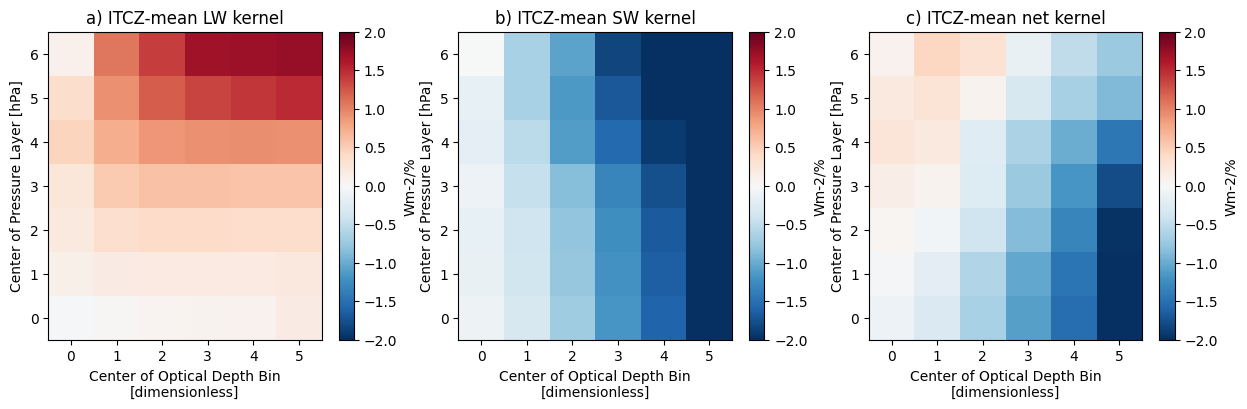

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))

#fig.suptitle('Horizontally stacked subplots')
lwK_itcz.mean(["lat","time"]).transpose().plot(cmap="RdBu_r", vmin=-2.0, vmax=2.0, cbar_kwargs={'label': "Wm-2/%", 'extend': 'neither'}, ax=ax1)
ax1.set_title("a) ITCZ-mean LW kernel")
swK_itcz.mean(["lat","time"]).transpose().plot(cmap="RdBu_r", vmin=-2.0, vmax=2.0, cbar_kwargs={'label': "Wm-2/%", 'extend': 'neither'}, ax=ax2)
ax2.set_title("b) ITCZ-mean SW kernel")
K_itcz.mean(["lat","time"]).transpose().plot(cmap="RdBu_r", vmin=-2.0, vmax=2.0, cbar_kwargs={'label': "Wm-2/%", 'extend': 'neither'}, ax=ax3)
ax3.set_title("c) ITCZ-mean net kernel")
#plt.savefig("kernels.png")

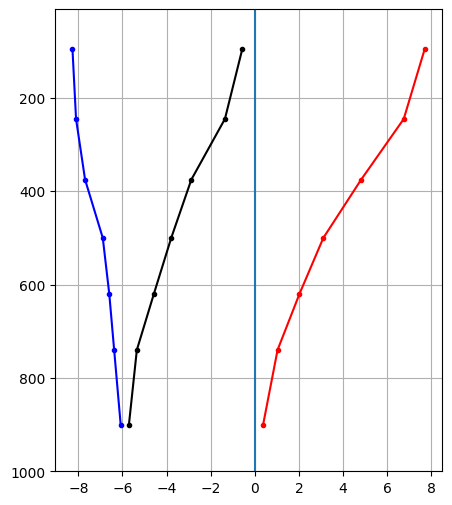

In [ ]:
plt.figure(figsize=(5,6))
plt.plot(lwK_itcz.mean(["lat","time"]).sum("opt"),  midpoints[1:], ".-r")
plt.plot(swK_itcz.mean(["lat","time"]).sum("opt"),  midpoints[1:], ".-b")
plt.plot(K_itcz.mean(["lat","time"]).sum("opt"), midpoints[1:], ".-k")
plt.gca().invert_yaxis()
plt.ylim(1000,10)
plt.vlines(0, ymin=1000, ymax=10)
plt.grid()

IN conclusion, kernels dont change much with area or time

In [ ]:
#2
area_itcz = alllw.cldarea_cldtyp_mon.sel(lat=itcz, lon=ocean_only,time=ragutime).mean("lon")
cc_itcz_anom = area_itcz.groupby('time.month')- area_itcz.groupby('time.month').mean('time')

In [ ]:
#3
lwR_itcz = lwK_itcz*cc_itcz_anom
swR_itcz = swK_itcz*cc_itcz_anom

In [ ]:
lw_itcz = np.cos(np.deg2rad(lwR_itcz.lat))

lwR_itcz_mean = lwR_itcz.weighted(weights=lw_itcz).mean("lat") 
swR_itcz_mean = swR_itcz.weighted(weights=lw_itcz).mean("lat")

In [ ]:
lw_feed_itcz =  np.zeros([7,6])
lw_feed_itcz_st =  np.zeros([7,6])

for od in [0,1,2,3,4,5]:
    for p in [0,1,2,3,4,5,6]:
        bints_itcz = lwR_itcz_mean.sel(press=p, opt=od)
        lw_regress  = stats.linregress(gmst_anom_raghu, bints_itcz)
        lw_feed_itcz[p, od] = lw_regress.slope
        lw_feed_itcz_st[p, od] = lw_regress.stderr

lwfeed_itcz = xa.DataArray(lw_feed_itcz,  
                    coords={"press": lwR_itcz_mean.press, "opt":lwR_itcz_mean.opt, 
                           },
                   )

lwfeed_itcz_st = xa.DataArray(lw_feed_itcz_st,  
                    coords={"press": lwR_itcz_mean.press, "opt":lwR_itcz_mean.opt, 
                           },
                   )

1.2117501084856193
High cloud ITCZ LW feedback = 
Low-mid cloud ITCZ LW feedback =  1.337571067966178


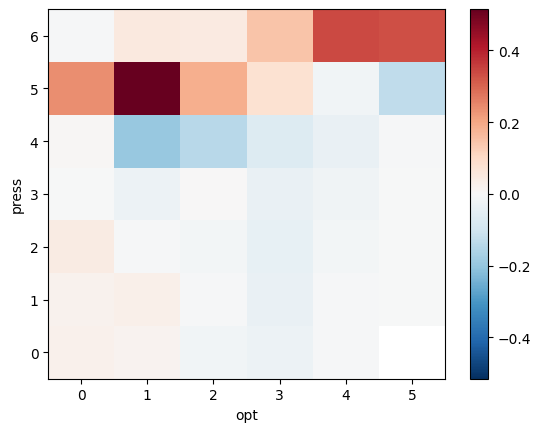

In [ ]:
print(lwfeed_itcz.sum(["press", "opt"]).data)
print("High cloud ITCZ LW feedback = ", )
print("Low-mid cloud ITCZ LW feedback = ", lwfeed_itcz.sel(press=[4,5,6]).sum(["press", "opt"]).data)
(lwfeed_itcz).plot() #vmin=-0.2, vmax=0.2, cmap="RdBu_r"

In [ ]:
sw_feed_itcz =  np.zeros([7,6])
sw_feed_itcz_st = np.zeros([7,6])

for od in [0,1,2,3,4,5]:
    for p in [0,1,2,3,4,5,6]:
        bints = swR_itcz_mean.sel(press=p, opt=od)
        sw_feed_itcz[p, od] = stats.linregress(gmst_anom_raghu, bints).slope
        sw_feed_itcz_st[p, od] = lw_regress.stderr


swfeed_itcz = xa.DataArray(sw_feed_itcz, 
                    coords={"press": swR_itcz_mean.press, "opt":swR_itcz_mean.opt, 
                           },
                   )
swfeed_itcz_st = xa.DataArray(sw_feed_itcz_st,  
                    coords={"press": swR_itcz_mean.press, "opt":swR_itcz_mean.opt, 
                           },
                   )

0.42744078240299394
High cloud ITCZ SW feedback =  -1.319930870039883
Low-mid cloud ITCZ SW feedback =  1.7473716524428773


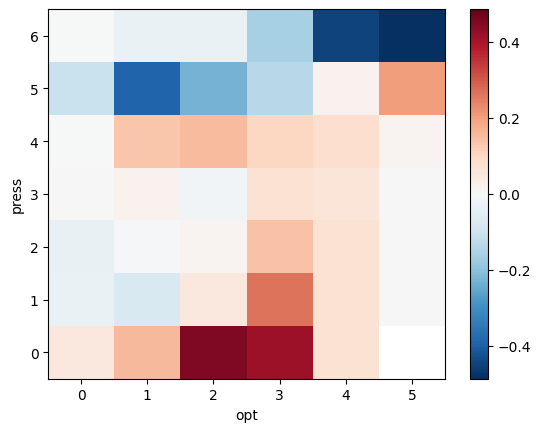

In [ ]:
print(swfeed_itcz.sum(["press", "opt"]).data)
print("High cloud ITCZ SW feedback = ", swfeed_itcz.sel(press=[4,5,6]).sum(["press", "opt"]).data)
print("Low-mid cloud ITCZ SW feedback = ", swfeed_itcz.sel(press=[0,1,2,3]).sum(["press", "opt"]).data)
(swfeed_itcz).plot() #vmin=-0.2, vmax=0.2, cmap="RdBu_r"

In [ ]:
#6
netR_itcz = K_itcz.mean("time")*cc_trop_anom
netR_itcz_mean = netR_itcz.mean(["lat"]) #weighted(weights=weights).

net_feed_itcz =  np.zeros([7,6])
net_feed_st = np.zeros([7,6])

for od in [0,1,2,3,4,5]:
    for p in [0,1,2,3,4,5,6]:
        bints = netR_itcz_mean.sel(press=p, opt=od)
        net_regress = stats.linregress(gmst_anom_raghu, bints)
        net_feed_itcz[p, od] = net_regress.slope
        net_feed_st[p, od] = net_regress.stderr

netfeed_itczr = xa.DataArray(net_feed_itcz, 
                    coords={"press": netR_itcz_mean.press, "opt":netR_itcz_mean.opt, 
                           },
                   )

netfeed_itcz_st = xa.DataArray(net_feed_st, 
                    coords={"press": netR_itcz_mean.press, "opt":netR_itcz_mean.opt, 
                           },
                   )

<xarray.DataArray ()>
array(0.40331225)
High cloud itcz net feedback =  0.10230429492250478
Low-mid cloud itcz net feedback =  0.30100795475258924
-0.31919735759779033 0.5238059474427998


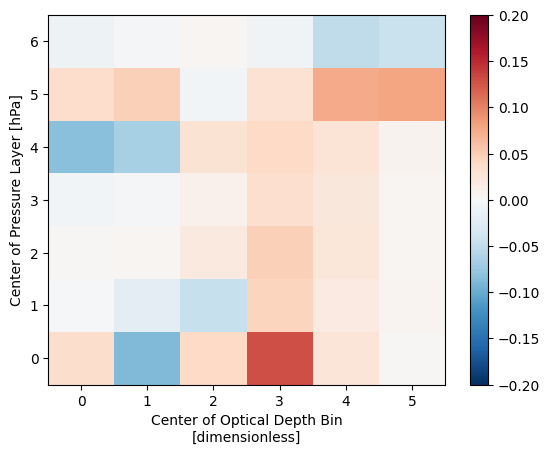

In [ ]:
#netfeed_itcz = swfeed_itcz + lwfeed_itcz
print(netfeed_itczr.sum(["press", "opt"]))
print("High cloud itcz net feedback = ", netfeed_itczr.sel(press=[4,5,6]).sum(["press", "opt"]).data)
print("Low-mid cloud itcz net feedback = ", netfeed_itczr.sel(press=[0,1,2,3]).sum(["press", "opt"]).data)
netfeed_itczr.plot(vmin=-0.2, vmax=0.2, cmap="RdBu_r") #


# Calculate the variance of the sum
variance_of_sum = netfeed_itcz_st.sel(press=[4,5,6]).sum(["press", "opt"])**2

# Standard deviation of the sum
sd_of_sum = np.sqrt(variance_of_sum.data)

# Calculate the critical t-value
t_value = t.ppf(0.975, df=222-1) # Number of data points per regression - Number of predictors (slope only)

# Confidence interval
ci = t_value * sd_of_sum
print(netfeed_itczr.sel(press=[4,5,6]).sum(["press", "opt"]).data - ci , netfeed_itczr.sel(press=[4,5,6]).sum(["press", "opt"]).data+ci)

Text(0.5, 1.0, 'c) ITCZ-mean net feedback')

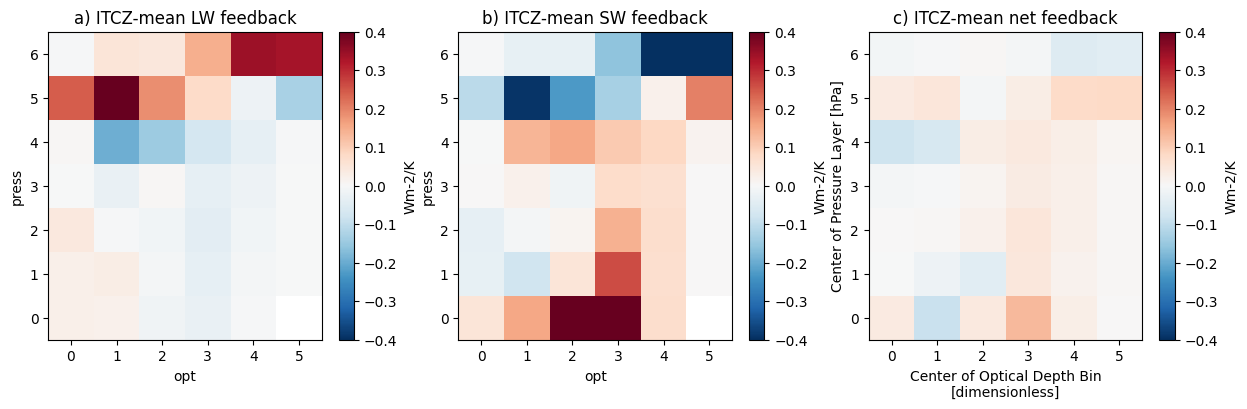

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))

#fig.suptitle('Horizontally stacked subplots')
lwfeed_itcz.plot(cmap="RdBu_r", vmin=-0.4, vmax=0.4, cbar_kwargs={'label': "Wm-2/K", 'extend': 'neither'}, ax=ax1)
ax1.set_title("a) ITCZ-mean LW feedback")
swfeed_itcz.plot(cmap="RdBu_r", vmin=-0.4, vmax=0.4, cbar_kwargs={'label': "Wm-2/K", 'extend': 'neither'}, ax=ax2)
ax2.set_title("b) ITCZ-mean SW feedback")
netfeed_itczr.plot(cmap="RdBu_r", vmin=-0.4, vmax=0.4, cbar_kwargs={'label': "Wm-2/K", 'extend': 'neither'}, ax=ax3)
ax3.set_title("c) ITCZ-mean net feedback")
#plt.savefig("feedbacks_itcz.png")

## Decomposition

In [ ]:
# Calculate the critical t-value
t_value = t.ppf(0.975, df=222-1) # Number of data points per regression - Number of predictors (slope only)

In [ ]:
#LW
a_ITCZ = feedback_amount(area_itcz.sel(press=[4,5,6]), lwK_itcz.sel(press=[4,5,6]), gmst_anom_raghu)

b_ITCZ = hc_feedbacks(area_itcz, lwK_itcz, "press")

c_ITCZ = hc_feedbacks(area_itcz, lwK_itcz, "opt")

hc_tot = lwfeed_itcz.sel(press=[4,5,6]).sum(["press", "opt"]).data

res_ITCZ =  hc_tot - a_ITCZ[0]-b_ITCZ[0]-c_ITCZ[0]

print(f"{hc_tot},  {a_ITCZ[0]},{b_ITCZ[0]},{c_ITCZ[0]},{res_ITCZ}") 

# Confidence interval
ci_a = t_value * a_ITCZ[1] #amount
print(ci_a, a_ITCZ[0] - ci_a ,a_ITCZ[0]+ci_a)

ci_b = t_value * b_ITCZ[1] #press
print(ci_b, b_ITCZ[0] - ci_b ,b_ITCZ[0]+ci_b)

ci_c = t_value * c_ITCZ[1] #opt
print(ci_c, c_ITCZ[0] - ci_c ,c_ITCZ[0]+ci_c)
#HC lw total 1.337571067966178


1.337571067966178,  1.313596581720907,0.16941544976425177,-0.3150654611394081,0.16962449762042742
1.781044177636481 -0.46744759591557394 3.0946407593573877
0.07272617994699725 0.09668926981725452 0.24214162971124903
0.47590347821405793 -0.790968939353466 0.16083801707464984


In [ ]:
#SW
a_ITCZ = feedback_amount(area_itcz.sel(press=[4,5,6]), swK_itcz.sel(press=[4,5,6]), gmst_anom_raghu)

b_ITCZ = hc_feedbacks(area_itcz, swK_itcz, "press")

c_ITCZ = hc_feedbacks(area_itcz, swK_itcz, "opt")

res_ITCZ = swfeed_itcz.sel(press=[4,5,6]).sum(["press", "opt"]).data - a_ITCZ-b_ITCZ-c_ITCZ

print(a_ITCZ,b_ITCZ,c_ITCZ,res_ITCZ) 

# Confidence interval
ci_a = t_value * a_ITCZ[1]
print( a_ITCZ[0] - ci_a ,a_ITCZ[0]+ci_a)

ci_b = t_value * b_ITCZ[1]
print( b_ITCZ[0] - ci_b ,b_ITCZ[0]+ci_b)

ci_c = t_value * c_ITCZ[1]
print( c_ITCZ[0] - ci_c ,c_ITCZ[0]+ci_c)

(-1.6699248508960622, 0.9556740817936238) (-0.01957809206977185, 0.00999910076110305) (0.5481017888383682, 0.40970119492961915) [-0.17852972 -2.69530525]
-3.553325540133783 0.21347583834165862
-0.039283882593957806 0.00012769845441410604
-0.2593194100956373 1.3555229877723738


In [ ]:
#Net
a_ITCZ = feedback_amount(area_itcz.sel(press=[4,5,6]), K_itcz.sel(press=[4,5,6]), gmst_anom_raghu)

b_ITCZ = hc_feedbacks(area_itcz, K_itcz, "press")

c_ITCZ = hc_feedbacks(area_itcz, K_itcz, "opt")

res_ITCZ = netfeed_itczr.sel(press=[4,5,6]).sum(["press", "opt"]).data - a_ITCZ-b_ITCZ-c_ITCZ

print(a_ITCZ,b_ITCZ,c_ITCZ,res_ITCZ) 

# Confidence interval
ci_a = t_value * a_ITCZ[1]
print(ci_a, a_ITCZ[0] - ci_a ,a_ITCZ[0]+ci_a)

ci_b = t_value * b_ITCZ[1]
print(ci_b, b_ITCZ[0] - ci_b ,b_ITCZ[0]+ci_b)

ci_c = t_value * c_ITCZ[1]
print(ci_c, c_ITCZ[0] - ci_c ,c_ITCZ[0]+ci_c)


(-0.35632827511278137, 0.09486755642620592) (0.1498373499917237, 0.029990756913100727) (0.23303635390372227, 0.17733405214376355) [ 0.07575887 -0.19988807]
0.18696083169282693 -0.5432891068056083 -0.16936744341995444
0.05910447224317695 0.09073287774854677 0.20894182223490065
0.3494821952333819 -0.11644584132965966 0.5825185491371042


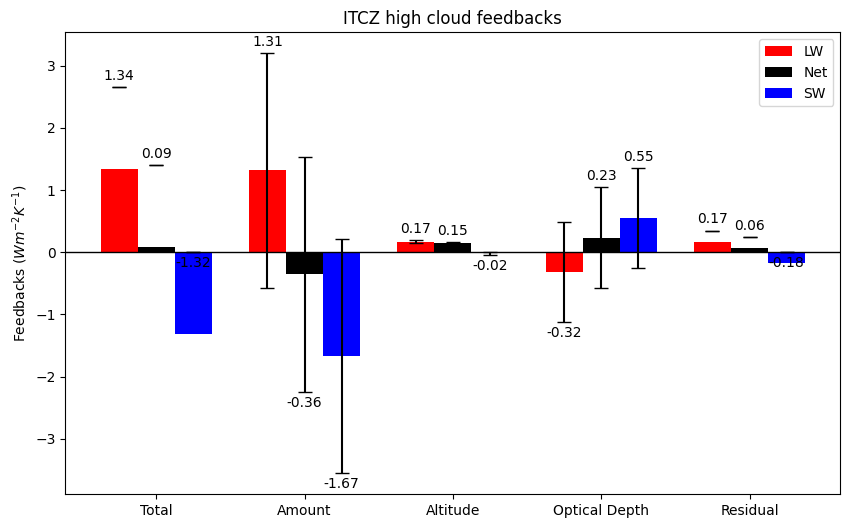

In [ ]:
decompos = ("Total", "Amount", "Altitude", "Optical Depth", "Residual")
feeds_itcz = {
    'LW': (1.337571067966178, 1.313596581720907, 0.16941544976425177, -0.3150654611394081, 0.16962449762042742),
    'Net': (0.08656580758728014, -0.35632827511278137, 0.1498373499917237, 0.23303635390372227, 0.0600203788046155),
    'SW': (-1.319930870039883, -1.6699248508960622 ,-0.01957809206977185, 0.5481017888383682, -0.17852971591241723),
}

ci_lower = {
    'LW': (0, -0.46744759591557394, 0.09668926981725452, -0.790968939353466, 0.0),
    'Net': (-0.31919735759779033, -0.5432891068056083, 0.09073287774854677, -0.11644584132965966, 0.0), 
    'SW': (0,-3.553325540133783, -0.039283882593957806, -0.2593194100956373, 0.0),
}
ci_upper = {
    'LW': (0, 3.0946407593573877, 0.24214162971124903, 0.16083801707464984, 0.0),
    'Net': (0.5238059474427998, -0.16936744341995444, 0.20894182223490065, 0.5825185491371042, 0.0),
    'SW': (0, 0.21347583834165862, 0.00012769845441410604, 1.3555229877723738, 0.0),
}


colors = {
    'LW': 'red',
    'Net': 'black',
    'SW': 'blue'
}

x = np.arange(len(decompos))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(10,6))

for attribute, measurement in feeds_itcz.items():
    offset = width * multiplier

    # Calculate asymmetric error bars
    #lower_errors = [m - ci for m, ci in zip(measurement, ci_lower[attribute])]
    #upper_errors = [ci - m for m, ci in zip(measurement, ci_upper[attribute])]
    #yerr_values = (lower_errors, upper_errors)

    rects = ax.bar(x + offset, measurement, width, label=attribute, yerr=yerr_values, capsize=5, color=colors[attribute]) 

    for i, rect in enumerate(rects):
        lower_bound = ci_lower[attribute][i]
        upper_bound = ci_upper[attribute][i]
    
        #if lower_bound <= 0 <= upper_bound:  # Not significant # Only apply to LW bars
        #    rect.set_facecolor('none')  # Remove filling for the first bar
        #    rect.set_edgecolor('red')

    ax.bar_label(rects, labels=[f"{value:.2f}" for value in measurement], padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(r'Feedbacks ($Wm^{-2}K^{-1}$)')
ax.set_title('ITCZ high cloud feedbacks')
ax.legend(loc='upper right')
ax.set_xticks(x + width)
ax.set_xticklabels(["Total", "Amount", "Altitude", "Optical Depth", "Residual"])
ax.axhline(0, color="black", linewidth=1)

plt.show()

Overall, feedbacks are larger, which makes sense because area is smaller. In conclusion, same pattern than in the Tropics for altitude and OD feedbacks. Amount ant total are the other way round for SW and LW, but net is the same. The total net is even more close to 0 in the ITCZ in comparison to the Pacific. 
I don't know why the residual is so high, and is positive for LW and Net in contrast to tropics.  

## EP

In [ ]:
def total_feedback(area, K):
    cc_anom = area.groupby("time.month") - area.groupby("time.month").mean("time")
    R = K.mean("time")*cc_anom
    R_mean = R.mean(["lat"]) #weighted(weights=weights).

    feed =  np.zeros([7,6])
    feed_st = np.zeros([7,6])

    for od in [0,1,2,3,4,5]:
        for p in [0,1,2,3,4,5,6]:
            bints = R_mean.sel(press=p, opt=od)
            net_regress = stats.linregress(gmst_anom_raghu, bints)
            feed[p, od] = net_regress.slope
            feed_st[p, od] = net_regress.stderr

    feed_r = xa.DataArray(feed, 
                        coords={"press": R_mean.press, "opt":R_mean.opt, 
                            },
                    )
    
    return feed_r, feed_st

In [ ]:
itcz = slice(-0.5, 20.5) #slice(5,15)
trop = slice(-30,30)
wp = slice(120,160)
cp = slice(160,200)
ep = slice(210,260)

In [ ]:
#sel press antes o despues de mean lon? puede ser causa del error
area_ep = alllw.cldarea_cldtyp_mon.sel(lat=itcz, lon=ep,time=ragutime).mean("lon")

RclrLW_ep = alllw.sel(lat=itcz,lon=ep, time=ragutime).toa_lw_clr_mon.mean("lon")
RovcLW_ep = alllw.sel(lat=itcz,lon=ep, time=ragutime).toa_lw_cldtyp_mon.mean("lon")
lwK_ep = (RclrLW_ep - RovcLW_ep)/100

RclrSW_ep = allsw.sel(lat=itcz,lon=ep, time=ragutime).toa_sw_clr_mon.mean("lon")
RovcSW_ep = allsw.sel(lat=itcz,lon=ep, time=ragutime).toa_sw_cldtyp_mon.mean("lon")
swK_ep = (RclrSW_ep - RovcSW_ep)/100

K_ep = lwK_ep + swK_ep

-0.831199579216985


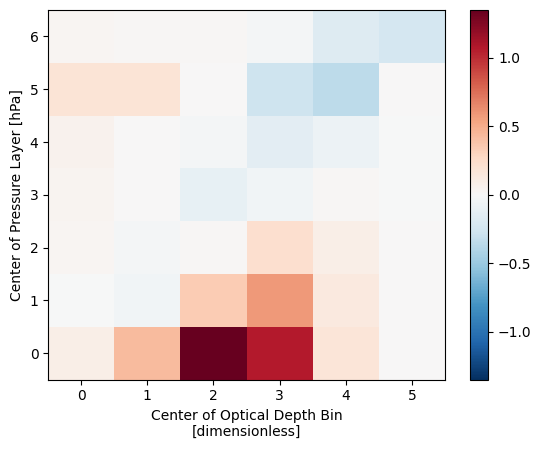

In [ ]:
feed_ep = total_feedback(area_ep, K_ep)
print(feed_ep.sel(press=[4,5,6]).sum(["press", "opt"]).data)
feed_ep.plot()

In [ ]:
#Net

a_ITCZ = feedback_amount(area_ep.sel(press=[4,5,6]), K_ep.sel(press=[4,5,6]), gmst_anom_raghu)

b_ITCZ = hc_feedbacks(area_ep, K_ep, "press")

c_ITCZ = hc_feedbacks(area_ep, K_ep, "opt")

res_ITCZ = feed_ep.sel(press=[4,5,6]).sum(["press", "opt"]).data - a_ITCZ-b_ITCZ-c_ITCZ

print(a_ITCZ,b_ITCZ,c_ITCZ,res_ITCZ) 


-1.1610233851237604 0.21949859025376017 0.04416796330652583 0.06615725234648939


-6.124803521369719


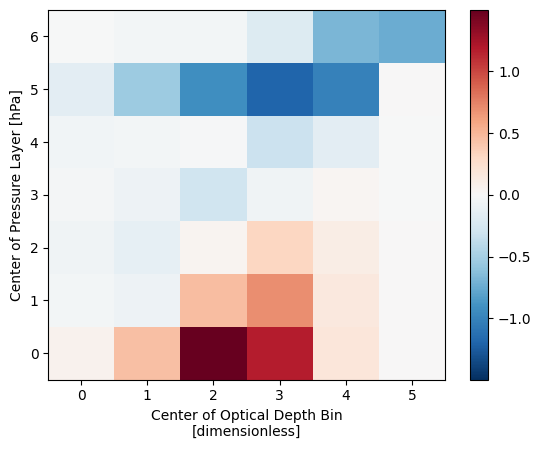

In [ ]:
swfeed_ep = total_feedback(area_ep, swK_ep)
print(swfeed_ep.sel(press=[4,5,6]).sum(["press", "opt"]).data)
swfeed_ep.plot()


In [ ]:
#SW
a_ITCZ = feedback_amount(area_ep.sel(press=[4,5,6]), swK_ep.sel(press=[4,5,6]), gmst_anom_raghu)

b_ITCZ = hc_feedbacks(area_ep, swK_ep, "press")

c_ITCZ = hc_feedbacks(area_ep, swK_ep, "opt")

res_ITCZ = swfeed_ep.sel(press=[4,5,6]).sum(["press", "opt"]).data - a_ITCZ-b_ITCZ-c_ITCZ

print(a_ITCZ,b_ITCZ,c_ITCZ,res_ITCZ) 

-6.256029390072807 0.012183149212189968 0.2923367514670991 -0.17329403197620122


5.29360490174959


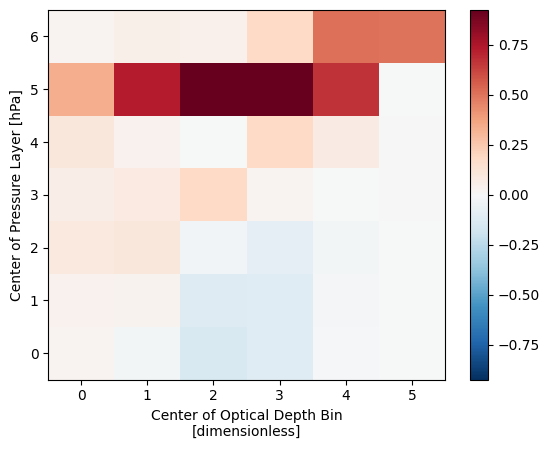

In [ ]:
lwfeed_ep = total_feedback(area_ep, lwK_ep)
print(lwfeed_ep.sel(press=[4,5,6]).sum(["press", "opt"]).data)
lwfeed_ep.plot()


In [ ]:
#LW
a_ITCZ = feedback_amount(area_ep.sel(press=[4,5,6]), lwK_ep.sel(press=[4,5,6]), gmst_anom_raghu)

b_ITCZ = hc_feedbacks(area_ep, lwK_ep, "press")

c_ITCZ = hc_feedbacks(area_ep, lwK_ep, "opt")

res_ITCZ = lwfeed_ep.sel(press=[4,5,6]).sum(["press", "opt"]).data - a_ITCZ-b_ITCZ-c_ITCZ

print(a_ITCZ,b_ITCZ,c_ITCZ,res_ITCZ) 

5.095005630913114 0.20741249352673896 -0.24813181444877305 0.23931859175850975


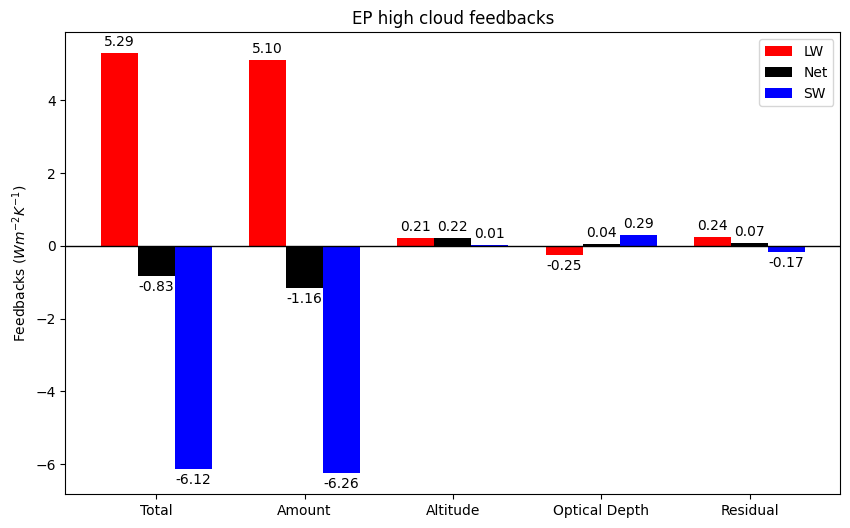

In [ ]:
decompos = ("Total", "Amount", "Altitude", "Optical Depth", "Residual")
feeds_ep = {
    'LW': (5.29360490174959, 5.095005630913114, 0.20741249352673896, -0.24813181444877305, 0.23931859175850975),
    'Net': (-0.831199579216985, -1.1610233851237604, 0.21949859025376017, 0.04416796330652583, 0.06615725234648939),
    'SW': (-6.124803521369719, -6.256029390072807, 0.012183149212189968, 0.2923367514670991, -0.17329403197620122),
}

colors = {
    'LW': 'red',
    'Net': 'black',
    'SW': 'blue'
}

x = np.arange(len(decompos))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(10,6))

for attribute, measurement in feeds_ep.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute,  color=colors[attribute]) #yerr=error_values, capsize=5
    ax.bar_label(rects, labels=[f"{value:.2f}" for value in measurement], padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(r'Feedbacks ($Wm^{-2}K^{-1}$)')
ax.set_title('EP high cloud feedbacks')
ax.legend(loc='upper right')
ax.set_xticks(x + width)
ax.set_xticklabels(["Total", "Amount", "Altitude", "Optical Depth", "Residual"])
ax.axhline(0, color="black", linewidth=1)

plt.show()

## WP

In [ ]:
#sel press antes o despues de mean lon? puede ser causa del error
area_wp = alllw.cldarea_cldtyp_mon.sel(lat=itcz, lon=wp,time=ragutime).mean("lon")

RclrLW_wp = alllw.sel(lat=itcz,lon=wp, time=ragutime).toa_lw_clr_mon.mean("lon")
RovcLW_wp = alllw.sel(lat=itcz,lon=wp, time=ragutime).toa_lw_cldtyp_mon.mean("lon")
lwK_wp = (RclrLW_wp - RovcLW_ep)/100

RclrSW_wp = allsw.sel(lat=itcz,lon=wp, time=ragutime).toa_sw_clr_mon.mean("lon")
RovcSW_wp = allsw.sel(lat=itcz,lon=wp, time=ragutime).toa_sw_cldtyp_mon.mean("lon")
swK_wp = (RclrSW_wp - RovcSW_wp)/100

K_wp = lwK_wp + swK_wp

1.304865476941059


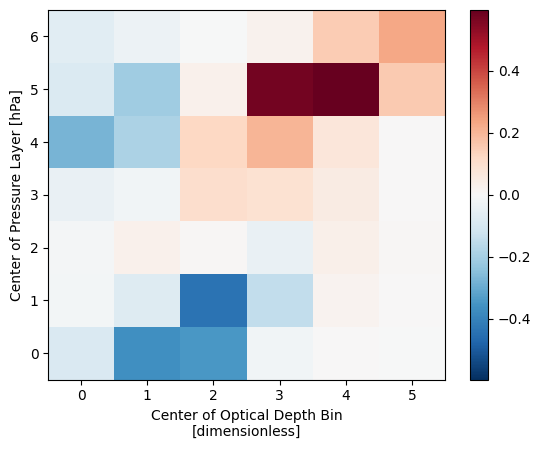

In [ ]:
feed_wp = total_feedback(area_wp, K_wp)
print(feed_wp.sel(press=[4,5,6]).sum(["press", "opt"]).data)
feed_wp.plot()

In [ ]:
#Net

a_ITCZ = feedback_amount(area_wp.sel(press=[4,5,6]), K_wp.sel(press=[4,5,6]), gmst_anom_raghu)

b_ITCZ = hc_feedbacks(area_wp, K_wp, "press")

c_ITCZ = hc_feedbacks(area_wp, K_wp, "opt")

res_ITCZ = feed_wp.sel(press=[4,5,6]).sum(["press", "opt"]).data - a_ITCZ-b_ITCZ-c_ITCZ

print(a_ITCZ,b_ITCZ,c_ITCZ,res_ITCZ) 

-0.7848795303138552 0.052104188855661225 1.4078898457143008 0.6297509726849522


10.773349440568133


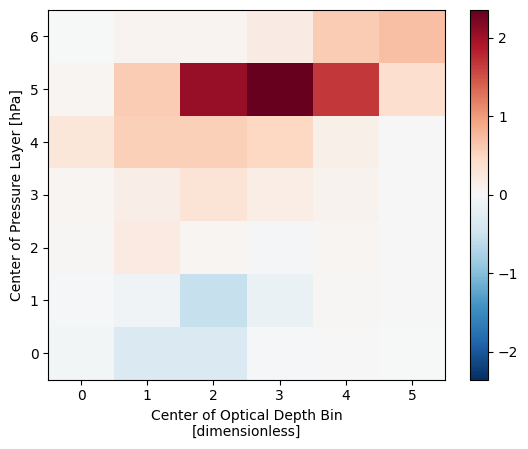

In [ ]:
swfeed_wp = total_feedback(area_wp, swK_wp)
print(swfeed_wp.sel(press=[4,5,6]).sum(["press", "opt"]).data)
swfeed_wp.plot()

In [ ]:
#SW
a_ITCZ = feedback_amount(area_wp.sel(press=[4,5,6]), swK_wp.sel(press=[4,5,6]), gmst_anom_raghu)

b_ITCZ = hc_feedbacks(area_wp, swK_wp, "press")

c_ITCZ = hc_feedbacks(area_wp, swK_wp, "opt")

res_ITCZ = swfeed_wp.sel(press=[4,5,6]).sum(["press", "opt"]).data - a_ITCZ-b_ITCZ-c_ITCZ

print(swfeed_wp.sel(press=[4,5,6]).sum(["press", "opt"]).data, a_ITCZ,b_ITCZ,c_ITCZ,res_ITCZ) 

10.773349440568133 7.6657906563413585 -0.04592645383388778 2.9055360005624027 0.24794923749825948


-9.47676572486305


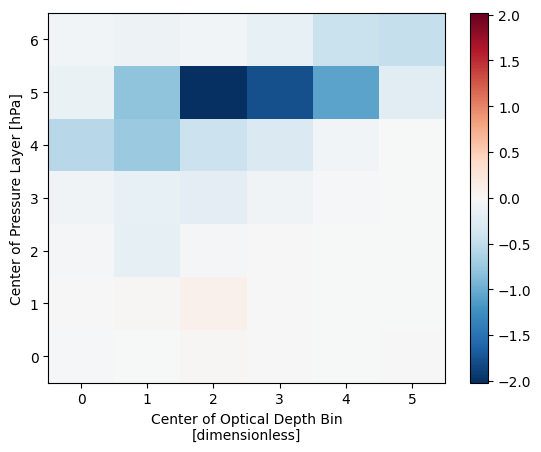

In [ ]:
lwfeed_wp = total_feedback(area_wp, lwK_wp)
print(lwfeed_wp.sel(press=[4,5,6]).sum(["press", "opt"]).data)
lwfeed_wp.plot()

In [ ]:
#LW
a_ITCZ = feedback_amount(area_wp.sel(press=[4,5,6]), lwK_wp.sel(press=[4,5,6]), gmst_anom_raghu)

b_ITCZ = hc_feedbacks(area_wp, lwK_wp, "press")

c_ITCZ = hc_feedbacks(area_wp, lwK_wp, "opt")

res_ITCZ = lwfeed_wp.sel(press=[4,5,6]).sum(["press", "opt"]).data - a_ITCZ-b_ITCZ-c_ITCZ

print(lwfeed_wp.sel(press=[4,5,6]).sum(["press", "opt"]).data, a_ITCZ,b_ITCZ,c_ITCZ,res_ITCZ) 

-9.47676572486305 -8.298435939408762 0.09813394131571623 -1.7281355279482058 0.4516718011782015


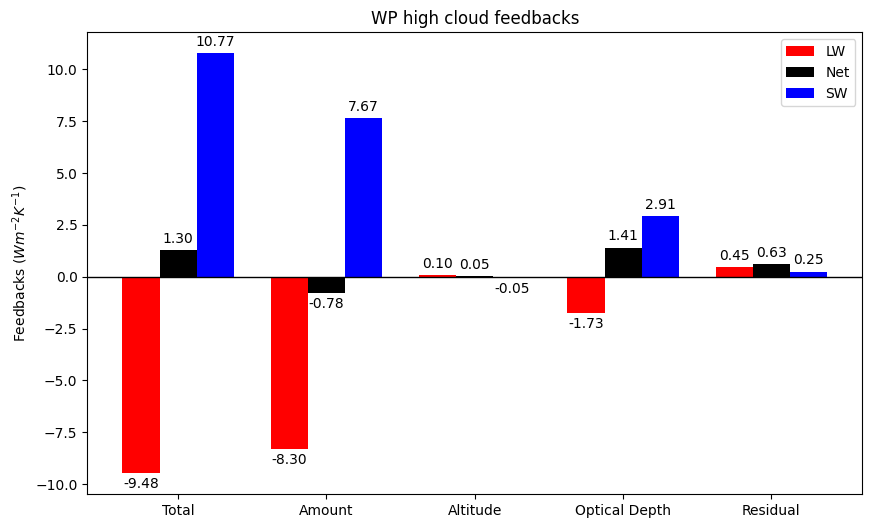

In [ ]:
decompos = ("Total", "Amount", "Altitude", "Optical Depth", "Residual")
feeds_wp = {
    'LW': (-9.47676572486305, -8.298435939408762 ,0.09813394131571623, -1.7281355279482058, 0.4516718011782015),
    'Net': (1.304865476941059, -0.7848795303138552, 0.052104188855661225, 1.4078898457143008, 0.6297509726849522),
    'SW': (10.773349440568133, 7.6657906563413585, -0.04592645383388778, 2.9055360005624027, 0.24794923749825948),
}

colors = {
    'LW': 'red',
    'Net': 'black',
    'SW': 'blue'
}

x = np.arange(len(decompos))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(10,6))

for attribute, measurement in feeds_wp.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute,  color=colors[attribute]) #yerr=error_values, capsize=5
    ax.bar_label(rects, labels=[f"{value:.2f}" for value in measurement], padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(r'Feedbacks ($Wm^{-2}K^{-1}$)')
ax.set_title('WP high cloud feedbacks')
ax.legend(loc='upper right')
ax.set_xticks(x + width)
ax.set_xticklabels(["Total", "Amount", "Altitude", "Optical Depth", "Residual"])
ax.axhline(0, color="black", linewidth=1)

plt.show()